## Загрузка библиотек

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE

## Загрузка данных

### Задание 1 (0.5 балла)

Для начала работы нам необходимо научиться читать набор данных. В данном домашнем задании мы поработаем с двумя наборами данных.

__covid.csv__ ([источник](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)) - статистика по вакцинированию от COVID19 по разным странам. Для данного датасета нет конкретной предсказательной переменной.

__hr.csv__ ([источник](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)) - набор данных большего размера. Он содержит статистику по людям, проходящим курсы по Big Data & ML. _Target_ - 1 или 0, сменил ли человек работу после прохождения курсов - или нет.

Реализуйте методы `read_covid_dataset` и `read_hr_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. В случае _covid_ датасета `y` возвращается как `None`. 

In [2]:
def read_covid_dataset(path_to_csv: str):
    df = pd.read_csv(path_to_csv)
    df["date"] = pd.to_datetime(df["date"])
    
    return df, None


def read_hr_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    
    return df.drop(columns="target"), df["target"]

In [3]:
DATA_DIR = "/Users/vladimirshitov/Documents/education/Bioinformatics_Institute/MachineLearning/data/"

COVID_DATA_PATH = f"{DATA_DIR}/covid.csv"
HR_DATA_PATH = f"{DATA_DIR}/hr.csv"

In [4]:
X_covid, _ = read_covid_dataset(COVID_DATA_PATH)
X_hr, y_hr = read_hr_dataset(HR_DATA_PATH)

In [5]:
print(X_covid.shape)

X_covid.head()

(2418, 15)


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Algeria,DZA,2021-01-29,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,Sputnik V,Ministry of Health,https://www.aps.dz/regions/116777-blida-covid-...
1,Algeria,DZA,2021-01-30,30.0,NaN,NaN,30.0,30.0,0.00,NaN,NaN,1.0,Sputnik V,Ministry of Health,https://www.aps.dz/regions/116777-blida-covid-...
2,Andorra,AND,2021-01-25,576.0,576.0,NaN,NaN,NaN,0.75,0.75,NaN,NaN,Pfizer/BioNTech,Government of Andorra,https://www.govern.ad/comunicats/item/12379-se...
3,Andorra,AND,2021-01-26,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,854.0,Pfizer/BioNTech,Government of Andorra,https://www.govern.ad/comunicats/item/12379-se...
4,Andorra,AND,2021-01-27,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,854.0,Pfizer/BioNTech,Government of Andorra,https://www.govern.ad/comunicats/item/12379-se...


In [6]:
print(X_hr.shape)

X_hr.head()

(19158, 13)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8


In [7]:
y_hr.head()

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: target, dtype: float64

## EDA

### Задание 2 (3.5 балла)

Выполните задание для датасетa _hr_.

Для дальнейшей работы с данными нужно обработать пропущенные значения в датасете.
Существуют различные стратегии обработки пропущенных данных.

#### 1. (0.5 балла)

Для числовых признаков постройте распределения признаков. Для категориальных признаков выведите статистику по количеству значений признака.

Числовых признаков немного, поэтому можно уместить их распределения (в том числе попарные) на одном графике:

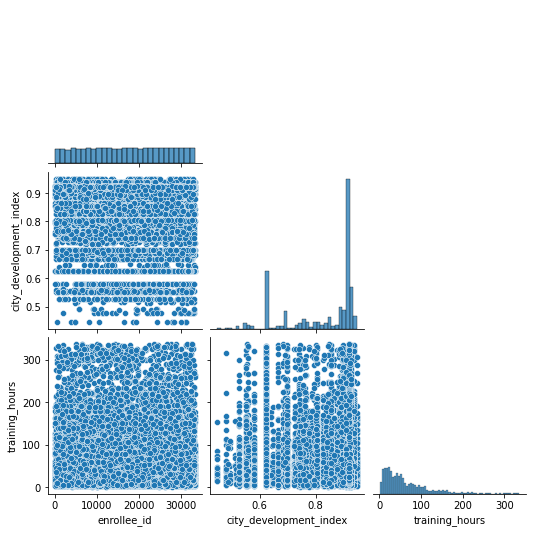

In [8]:
sns.pairplot(X_hr.select_dtypes('number'), corner=True)

Количество категорий (считая пропущенные значения):

In [9]:
X_hr.select_dtypes("object").apply(lambda feature: len(feature.unique()))

city                   123
gender                   4
relevent_experience      2
enrolled_university      4
education_level          6
major_discipline         7
experience              23
company_size             9
company_type             7
last_new_job             7
dtype: int64

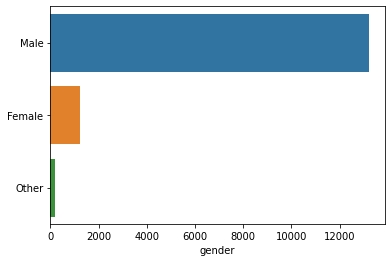

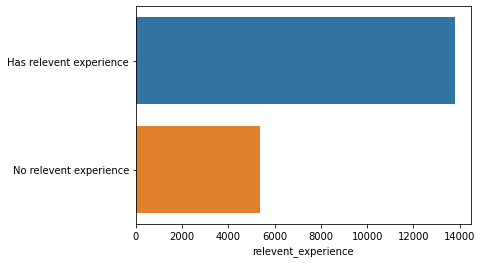

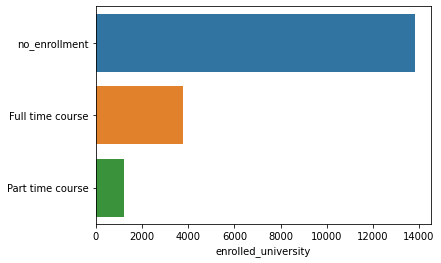

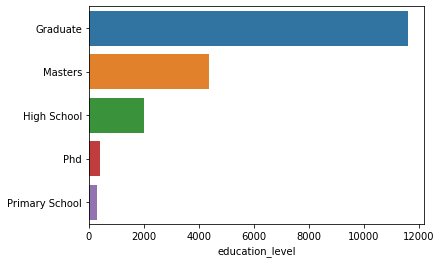

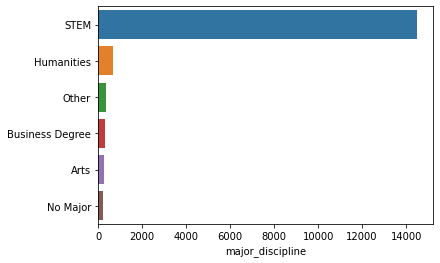

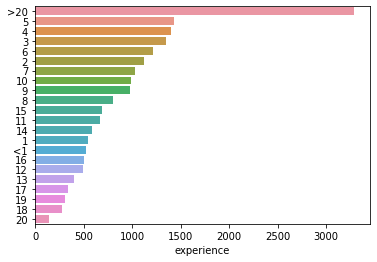

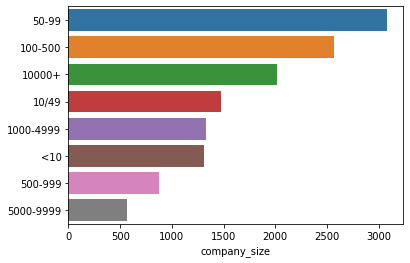

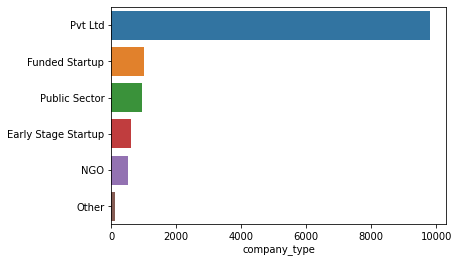

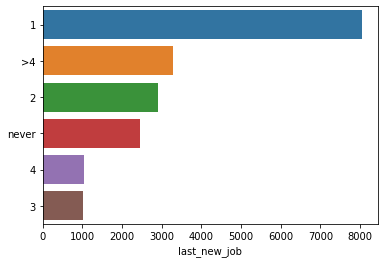

In [10]:
for col in X_hr.select_dtypes("object").columns[1: ]:  # Drop "city" as it's ugly
    categories_count = X_hr[col].value_counts()
    sns.barplot(x=categories_count, y=categories_count.index, orient="h")
    plt.show()

#### 2. (0.5 балла)
Удалите все строки, где есть хотя бы одно пропущенное значение признака. Насколько сильно уменьшился размер датасета? Как изменились распределения признаков/статистика по количеству значений признаков?

In [11]:
print(f'Исходный размер датасета hr {X_hr.shape[0]}')

Исходный размер датасета hr 19158


In [12]:
X_hr_dropna = X_hr.dropna()

In [13]:
print(f'Pазмер датасета hr без NaN {X_hr_dropna.shape[0]}')

Pазмер датасета hr без NaN 8955


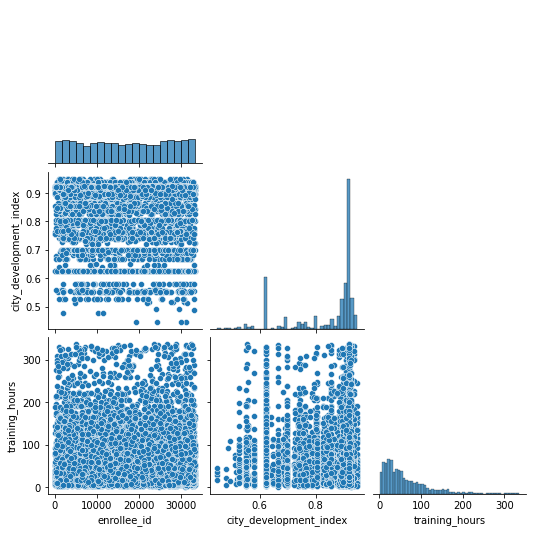

In [14]:
sns.pairplot(X_hr_dropna.select_dtypes('number'), corner=True)

Размер датасета уменьшился больше, чем в 2 раза, распределения количественных признаков визуально не поменялись

Давайте попробуем избежать сокращения размера датасета.

#### 3.  (1 балл)
Для числовых признаков заполните пропущенные данные средним/медианой/модой данного признака. Объясните свой выбор. (Часть строк с NaN значениями можно удалить, если размер датасета уменьшится <15%)

In [15]:
X_hr.select_dtypes("number").isna().sum()

enrollee_id               0
city_development_index    0
training_hours            0
dtype: int64

Пропущенных данных в числовых признаках нет. Поэтому их распределения на графике выше определённо не поменялись

Если бы пропущенные значения всё же были, я бы заменил их **модой** для признака `city_development_index`: в нём видно большой пик около 0,9, среднее и медиана могли бы несколько исказить такое распределение. В признак `enrollee_id` я бы добавил **новые значения**, которых не было в датасете, исходя из смысла признака. Для признака `training_hours` можно было бы заменить пропущенные значения **медианой**

#### 4.  (1 балл)
Для категориальных признаков заполните пропущенные значения самой встречающейся категорией или создайте отдельную категорию пропущенных значений. Объясните свой выбор. (Часть строк с NaN значениями можно удалить, если размер датасета уменьшится <15%)

Количество пропущенных значений:

In [16]:
X_hr.select_dtypes("object").isna().sum()

city                      0
gender                 4508
relevent_experience       0
enrolled_university     386
education_level         460
major_discipline       2813
experience               65
company_size           5938
company_type           6140
last_new_job            423
dtype: int64

Доля пропущенных значений:

In [17]:
X_hr.select_dtypes("object").isna().sum() / X_hr.shape[0]

city                   0.000000
gender                 0.235306
relevent_experience    0.000000
enrolled_university    0.020148
education_level        0.024011
major_discipline       0.146832
experience             0.003393
company_size           0.309949
company_type           0.320493
last_new_job           0.022080
dtype: float64

Поступим следующим образом:
- В полях `gender`, `relevent_experience` явно укажем, что значения пропущены, так как можно ожидать отличия между разными категориями и заполнять модой их будет некорректно. Также поступим с полями `company_size` и `company_type`, так как пропущенных значений в них много, а в первом случае ещё и нет явно преобладающей категории. Заполнив их модой, можно увеличить шум
- Пропущенные значения в полях `enrolled_university`, `education_level`, `major_discipline`, `last_new_job` заполним модой, так как в них есть явно преобладающая категория, а пропущенных значений не очень много
- Строки с пропущенными значениями в поле `experience` можно опустить, так как их немного

In [19]:
def fill_na(X, y):
    
    X_fill = X.copy()
    y_fill = y.copy()
    
    cols_to_fill_with_unknown = ["gender", "relevent_experience", "company_size", "company_type"]
    cols_to_fill_with_mode = ["enrolled_university", "education_level", "major_discipline", "last_new_job"]
    
    for col in cols_to_fill_with_unknown:
        X_fill[col] = X_fill[col].fillna("unknown")

    for col in cols_to_fill_with_mode:
        mode = X_fill[col].mode()[0]  # Sometimes there are several modes, select the first one
        X_fill[col] = X_fill[col].fillna(mode)
    
    X_fill = X_fill[~X_fill["experience"].isna()]
    y_fill = y_fill.loc[X_fill.index]  # Drop rows from target as well
    
    return X_fill, y_fill

In [20]:
X_hr_fill, y_hr_fill = fill_na(X_hr, y_hr)

In [40]:
X_hr_fill.shape

(19093, 13)

#### 5.  (0.5 балла)
Как изменились распределения признаков/статистика по количеству значений признаков после заполнения пропущенных данных?

In [21]:
X_hr_fill.select_dtypes("object").isna().sum()

city                   0
gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

Как и ожидалось – все пропущенные значения заполнены или удалены. Проверим также, что индекс X и y одинаков:

In [22]:
all(X_hr_fill.index == y_hr_fill.index)

True

### Задание 3  (1 балл)

Выполните задание для датасета _covid_.

1. Найдите страну, для которой в датасете присутствует 46 дат со статистикой по вакцинации.
2. Постройте для этой страны график зависимости _total_vaccinations_ от _date_.
3. Заполните пропущенные данные о _total_vaccinations_ для этой страны. Объясните свой выбор.

In [23]:
country_counts = X_covid["country"].value_counts()
country_counts[country_counts == 46]

Bahrain    46
Name: country, dtype: int64

_Это Бахрэйн_

### Задание  4 (0.5 балла)
Выполните задание для датасета _hr_.

Есть ли в данных выбросы? Если да, то скажите, какие и почему Вы считаете их выбросами?


<Figure size 1080x1080 with 0 Axes>

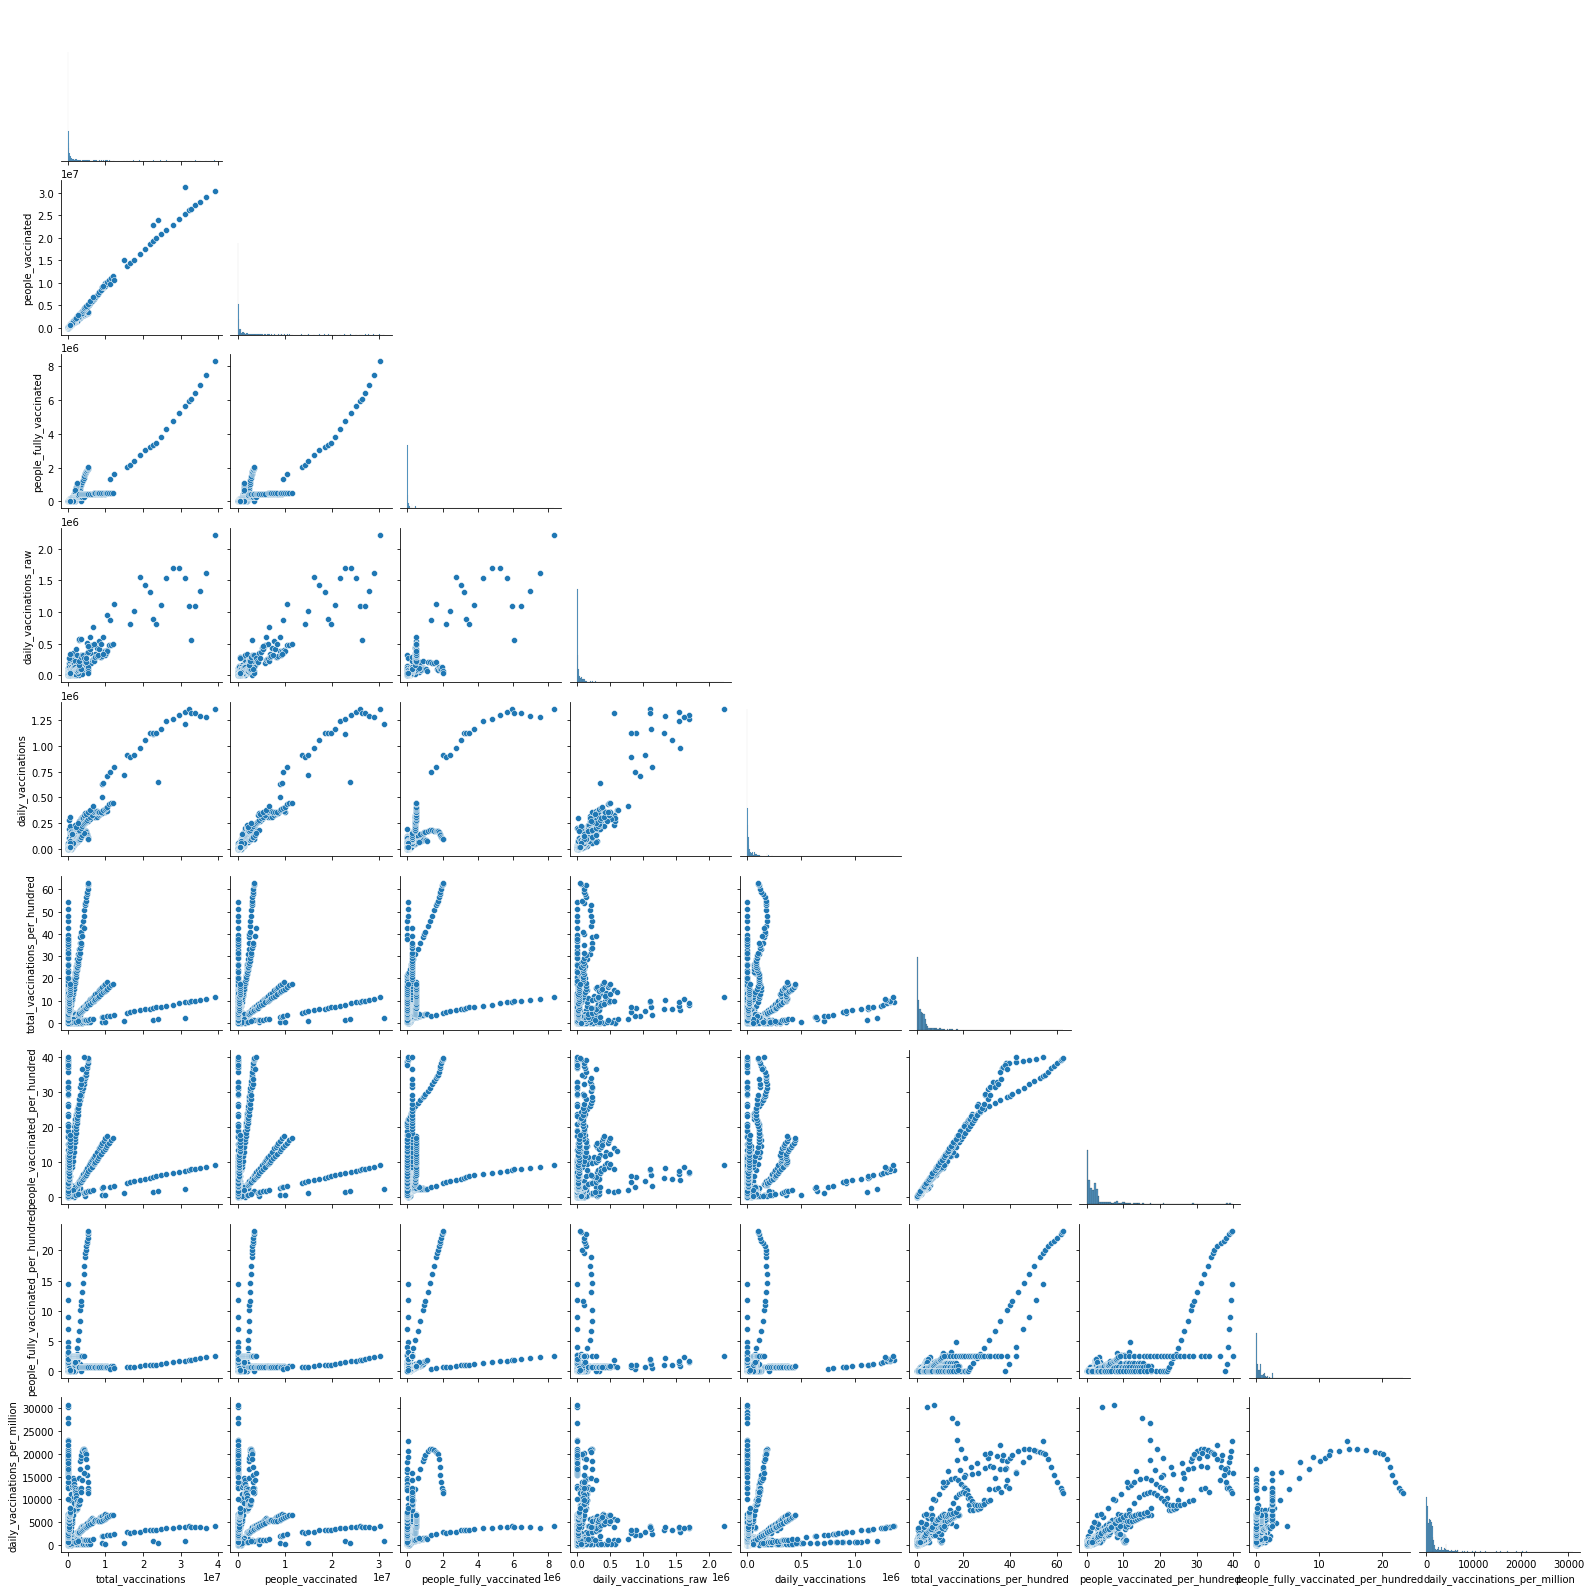

In [24]:
plt.figure(figsize=(15, 15))
sns.pairplot(X_covid.select_dtypes("number"), corner=True)

Если смотреть на гистограммы, может показаться, что в длинных хвостах есть выбросы. Однако, совместные распределения выглядят хорошо, в них наблюдаются закономерности и нет отдельно стоящих точек. Кроме того, ясно, что распределения числовых признаков сильно зависит от страны:

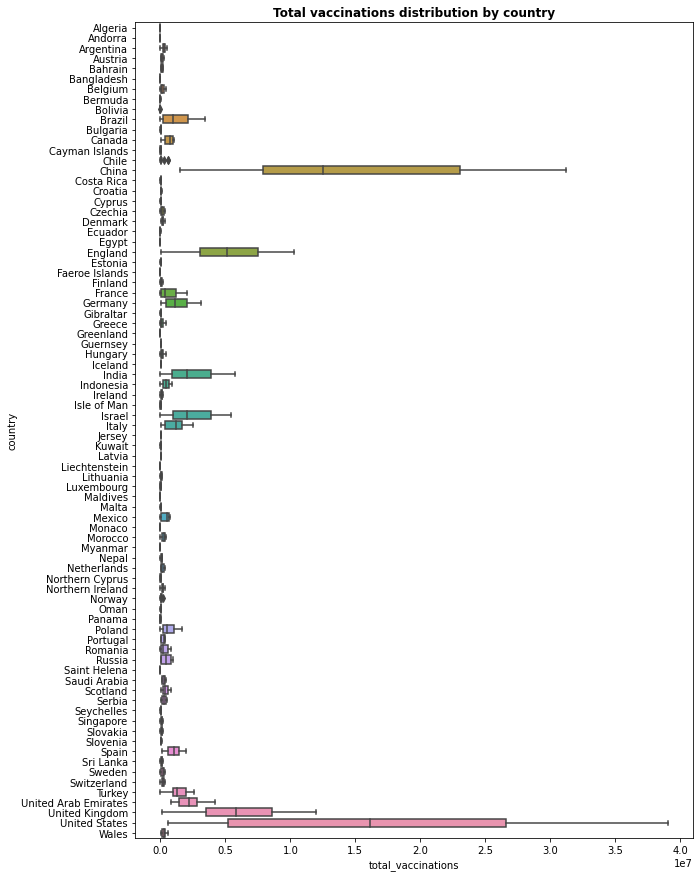

In [25]:
plt.figure(figsize=(10, 15))
sns.boxplot(data=X_covid, y="country", x="total_vaccinations")
plt.title("Total vaccinations distribution by country", fontweight="bold");

Если смотреть на распределения некоторых признаков по дате, то видны резкие скачки вверх и вниз:

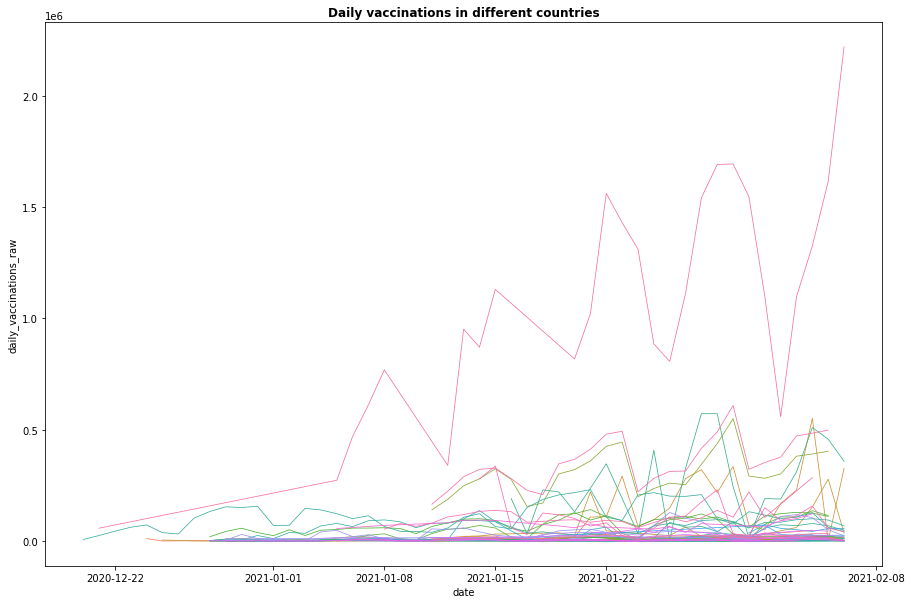

In [26]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=X_covid, x="date", y="daily_vaccinations_raw", hue="country", legend=False, size=0.1)
plt.title("Daily vaccinations in different countries", fontweight="bold");

Это может отражать сезонные особенности поведения людей (например, в выходные люди могут более или менее активно вакцинироваться, чем в будние дни) или искажения в данных. Сложно сказать, можно ли считать их выбросами, но обычно такие вещи сглаживаются (например, скользящим средним). Судя по данным, это сделано в столбце `daily_vaccinations`

В целом, количественные признаки выглядят довольно чистыми и явных выбросов не видно

Что касается категориальных переменных, здесь есть мешанина в столбце с вакцинами:

In [27]:
X_covid["vaccines"].value_counts()

Pfizer/BioNTech                          1057
Moderna, Pfizer/BioNTech                  624
Oxford/AstraZeneca, Pfizer/BioNTech       275
Sputnik V                                  79
Pfizer/BioNTech, Sinopharm                 79
Pfizer/BioNTech, Sinovac                   54
Sinopharm, Sinovac                         51
Sinovac                                    51
Oxford/AstraZeneca, Sinopharm              36
Oxford/AstraZeneca                         31
Pfizer/BioNTech, Sinopharm, Sputnik V      29
Covaxin, Oxford/AstraZeneca                23
Oxford/AstraZeneca, Sinovac                22
Sinopharm                                   7
Name: vaccines, dtype: int64

Некоторые вакцины записаны совместно через запятую. Это не совсем выбросы, но грязноватые данные. Лучше разнести эту информацию по нескольким столбцам

### Задание  5 (1 балл)
Выполните задание для датасета _hr_.

Закодируйте категориальные признаки при помощи One-hot encoding/Label encoding/Frequency encoding. Объясните свой выбор. (Обратите внимание, что некоторые категориальные признаки предполагают ранжирование в своих значениях)

- Закодируем признаки `enrolled_university`, `last_new_job`, `education_level`, `relevent_experience`, `experience`  при помощи **Label encoding** (записав руками нужный порядок классов), чтобы сохранить информацию о ранжировании
- Для признака `city` лучше использовать **Frequency encoding**. Label encoding не подойдёт из-за того, что он задаст порядок на городах, что вряд ли имеет смысл. One-hot encoding не подходит из-за большого количества категорий: при таком кодировании получится 123 новых признака
- Остальное закодируем при помощи **One-hot encoding**

Для частотного кодирования использую **LeaveOneOutEncoder**, который для каждого наблюдения кодирует частоту целевого признака без учёта этого наблюдения. Это приводит к меньшему лику таргета в кодировку

In [28]:
def encode(X, y):
    enrolled_university_to_numbers = {
        "no_enrollment": 0,
        "Part time course": 1,
        "Full time course": 2
    }
    
    last_new_job_to_numbers = {
        "never": 0,  # Tricky one, as it means that a person never had a job. Maybe should be a big number instead
        "1": 1,  # Changed a job 1 year ago
        "2": 2,
        "3": 3,
        "4": 4,
        ">4": 5  # Changed a job >4 years ago
    }
    
    relevant_experience_to_numbers = {
        "No relevent experience": 0,
        "Has relevent experience": 1
    }
    
    # We could also use amount of years to get education level as a heuristic
    # E.g. 11 for High School, 15 for Graduate, 17 for Masters
    education_level_to_numbers = {
        "Primary School": 0,
        "High School": 1,
        "Graduate": 2,  # It means university, right? Tbh, not sure
        "Masters": 3,
        "Phd": 4
    }
    
    X_encode = X.copy()
    
    X_encode["enrolled_university"] = X["enrolled_university"].map(enrolled_university_to_numbers)
    X_encode["last_new_job"] = X["last_new_job"].map(last_new_job_to_numbers)
    X_encode["relevent_experience"] = X["relevent_experience"].map(relevant_experience_to_numbers)
    X_encode["education_level"] = X["education_level"].map(education_level_to_numbers)
    
    X_encode["experience"] = X["experience"].replace({">20": 21, "<1": 0}).astype(int)
    
    encoder = ce.LeaveOneOutEncoder()
    X_encode["city"] = encoder.fit_transform(X_encode["city"], y)

    X_encode = pd.get_dummies(X_encode, columns=["gender", "major_discipline", "company_size"])
    
    return X_encode

In [29]:
X_hr_encode = encode(X_hr_fill, y_hr_fill)

X_hr_encode.head()

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_type,last_new_job,training_hours,...,major_discipline_STEM,company_size_10/49,company_size_100-500,company_size_1000-4999,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_size_unknown
0,8949,0.212869,0.920,1,0,2,21,unknown,1,36,...,1,0,0,0,0,0,0,0,0,1
1,29725,0.149254,0.776,0,0,2,15,Pvt Ltd,5,47,...,1,0,0,0,0,1,0,0,0,0
2,11561,0.592027,0.624,0,2,2,5,unknown,0,83,...,1,0,0,0,0,0,0,0,0,1
3,33241,0.377358,0.789,0,0,2,0,Pvt Ltd,0,52,...,0,0,0,0,0,0,0,0,0,1
4,666,0.291339,0.767,1,0,3,21,Funded Startup,4,8,...,1,0,0,0,0,1,0,0,0,0


### Задание  5 (1 балл)
Выполните задание для датасета _hr_.




#### 1.  (1 балл)
Реализуйте функцию undersampling

#### 2.  (1 балл)
Реализуйте функцию oversampling

In [31]:
def undersampling(X, y):
    # Возвращает данные, сбалансированные методом undersampling
    classes_counts = y.value_counts()
    
    overpresent_class = classes_counts.argmax()
    n_observations = classes_counts.min()
    
    observations_to_take = np.random.choice(y[y == overpresent_class].index, size=n_observations)
    
    # Take all observations of the underpresent class, and a subset of observations from overpresent class
    X_under = pd.concat([X[y != overpresent_class], X.loc[observations_to_take]], ignore_index=True)
    y_under = pd.concat([y[y != overpresent_class], y.loc[observations_to_take]], ignore_index=True)
    
    new_index = np.arange(X_under.shape[0])
    
    return X_under.set_index(new_index), y_under

def oversampling(X, y):
    # Возвращает данные, сбалансированные методом oversampling
    classes_counts = y.value_counts()
    
    underpresent_class = classes_counts.argmin()
    n_observations = classes_counts.max() - classes_counts.min()
    
    observations_to_take = np.random.choice(y[y == underpresent_class].index, size=n_observations)
    
    # Add a subset of observations to the original data frame
    X_over = pd.concat([X, X.loc[observations_to_take]], ignore_index=True)
    y_over = pd.concat([y, y.loc[observations_to_take]], ignore_index=True)
    
    new_index = np.arange(X_over.shape[0])
    
    return X_over.set_index(new_index), y_over

In [41]:
print(X_hr_fill.shape)
print(y_hr_fill.value_counts())

(19093, 13)
0.0    14339
1.0     4754
Name: target, dtype: int64


In [33]:
X_hr_under, y_hr_under = undersampling(X_hr_encode, y_hr_fill)

X_hr_over, y_hr_over = oversampling(X_hr_encode, y_hr_fill)

In [34]:
print(X_hr_under.shape)
print(y_hr_under.value_counts())

(9508, 29)
1.0    4754
0.0    4754
Name: target, dtype: int64


In [35]:
print(X_hr_over.shape)
print(y_hr_over.value_counts())

(28678, 29)
1.0    14339
0.0    14339
Name: target, dtype: int64


Убедимся, что в `X` и `y` одинаковое количество наблюдений:

In [36]:
assert X_hr_encode.shape[0] == y_hr_fill.shape[0]
assert X_hr_under.shape[0] == y_hr_under.shape[0]
assert X_hr_over.shape[0] == y_hr_over.shape[0]

#### 3.  (1 балл)
Используйте _SMOTE_ для балансировки датасета.

Помимо методов _undersampling_ и _oversampling_ существует подход, генерирующий элементы класса-меньшинства, похожие на уже присутствующие в выборке данных. Такой метод называется _Synthetic Minority Oversampling Technique_ (SMOTE). 

Метод _SMOTE_ , реализованный в библиотеке `imblearn`, генерирует синтетические примеры при помощи __k-nearest neighbor__ алгоритма (подробнее об этом алгоритме будет рассказано на лекции).

In [37]:
smote = SMOTE()
X_hr_SMOTE, y_hr_SMOTE = smote.fit_resample(X_hr_encode.select_dtypes("number"), y_hr_fill)

#### 4. (0.5 балла)
Как изменились распределения признаков при различных тактиках балансирования датасета?

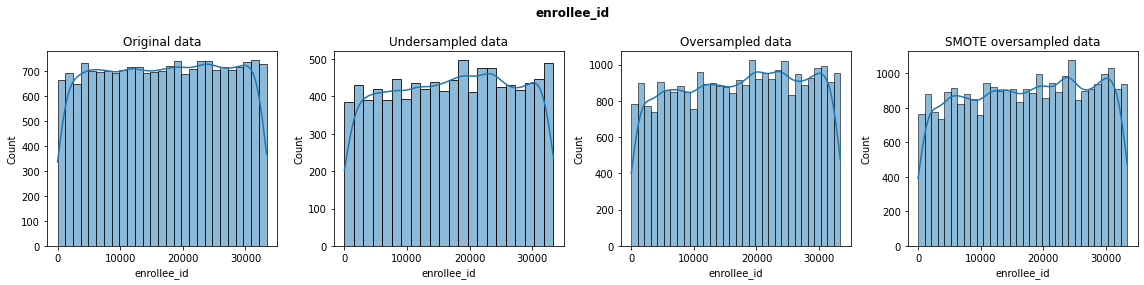

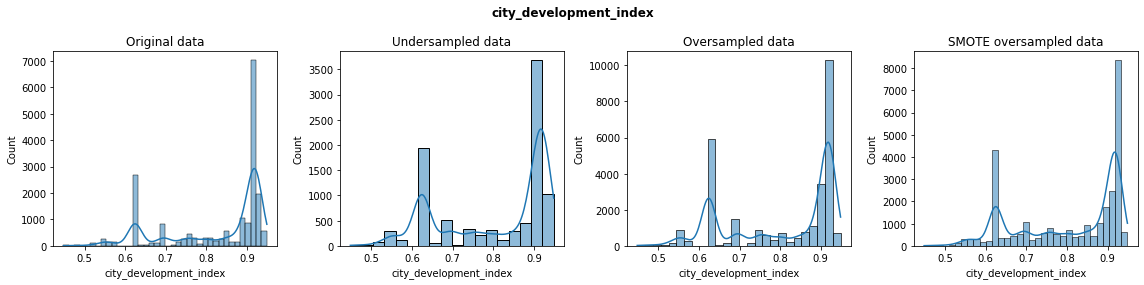

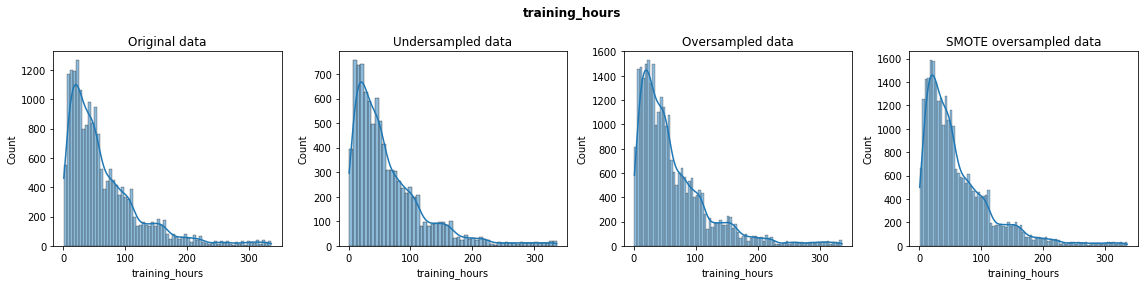

In [38]:
numeric_cols = X_hr.select_dtypes("number").columns

for col in numeric_cols:
    fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
    
    for i, df in enumerate([X_hr_encode, X_hr_under, X_hr_over, X_hr_SMOTE]):
        sns.histplot(x=df[col], ax=axes[i], kde=True)
    
    axes[0].set_title("Original data")
    axes[1].set_title("Undersampled data")
    axes[2].set_title("Oversampled data")
    axes[3].set_title("SMOTE oversampled data")
        
    fig.suptitle(col, fontweight="bold")
    fig.tight_layout()

Распределение числовых признаков после балансирования не изменилось судя по визуальному критерию (не говорите об этой фразе нашему преподавателю по статистике). Такое же поведение можно ожидать и для категориальных данных, хотя восстанавливать их после перекодировки – несколько громоздкая задача